In [1]:
import io
import subprocess
import os

from tensorflow.compat.v1.keras import layers
import tensorflow.compat.v1 as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from tf_graph_util import convert_variables_to_constants
from lstm import create_lstm

from seq2seq import create_seq2seq

In [2]:
RANDOM_SEED = 42

In [58]:
import os
def benchmark_model(model, cmd=None):
    bench_path = f"{model.name}_benchmark.txt"
    if not os.path.exists(f"{model.name}.pbtxt") and not os.path.exists(bench_path):
        if not os.path.exists(f"{model.name}.pbtxt"):
            print("Saving model...")
#             tf.keras.backend.clear_session()
            sess = tf.keras.backend.get_session()
    #         output_graph_def = tf.graph_util.convert_variables_to_constants(
            output_graph_def = convert_variables_to_constants(
                sess,
                sess.graph.as_graph_def(),
                [node.op.name for node in model.outputs])
            tf.io.write_graph(output_graph_def, './', f'{model.name}.pbtxt')
        else:
            print("Retrieving saved model.")
    
    
        if not os.path.exists(bench_path):
            if not cmd:
                input_shape = f"1,{','.join(str(dim) for dim in model.input.shape[1:])}"
                cmd = f'../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph={model.name}.pbtxt --input_layer="{model.input.name}" --input_layer_shape="{input_shape}" --output_layer="{model.output.name}"'
                print(cmd)
            print("Running benchmark...")
            benchmark = subprocess.run([cmd], stderr=subprocess.PIPE, shell=True)
            print("Done.")

            output = benchmark.stderr.decode('unicode_escape')
            split_output = output[output.find('Run Order'):output.find('Top by Computation Time')].split('\n')

            with open(bench_path, 'w') as f:
                f.write("\n".join(split_output[1:-2]))
        else:
            print("Retrieving saved benchmark results.")
    else:
        print("Retrieving saved model and benchmark results.")
    
    f = open(bench_path)
    benchmark = pd.read_csv(f, sep="\t").rename(columns=lambda x: x.strip())
    benchmark = benchmark.drop(benchmark.columns[0], axis=1)
    benchmark['name'] = benchmark['[Name]'].apply(lambda x: x.split('/')[0])
    return benchmark

In [4]:
def get_layer_features(model):
    layers = pd.DataFrame()
    layers['name'] = pd.Series([layer.name for layer in model.layers])
    
#     input_dims = {layer.name: [dim.value for dim in layer.input.shape.dims] for layer in model.layers}
    
#     layers['input_shape'] = pd.Series([[dim.value for dim in layer.input.shape.dims] for layer in model.layers])
#     layers['output_shape'] = pd.Series([[dim.value for dim in layer.output.shape.dims] for layer in model.layers])
    layers['input_shape'] = pd.Series([layer.input_shape for layer in model.layers])
    layers['output_shape'] = pd.Series([layer.output_shape for layer in model.layers])

    features = ['units','filters','activation','strides','kernel_size']
    for feature in features:
        layers[feature] = pd.Series(
            [layer.get_config()[feature] if feature in layer.get_config() else None for layer in model.layers])
    return layers

In [5]:
def join_benchmark(features, benchmark):
    speed = benchmark[['name', '[avg ms]']].groupby('name').sum()
    mem = benchmark[['name', '[mem KB]']].groupby('name').max()
    
    return features.join(speed, on='name').join(mem, on='name')

In [6]:

def flatten_shape(shape):
    if not shape:
        return None
    
    def reduce(tup):
        acc = 1
        for val in tup:
            if val:
                acc *= val
        return acc
    
    if isinstance(shape, list):
        return sum(reduce(tup) for tup in shape)
    
    return reduce(shape)


def clean(data, inference=False):
    if inference:
        cleaned = pd.get_dummies(data, columns=['activation'], dummy_na=True)
    else:
        cleaned = pd.get_dummies(
            data.dropna(subset=['[avg ms]', '[mem KB]']), columns=['activation'], dummy_na=True)
    
    for activation in ['selu', 'elu', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'exponential', 'linear']:
        col = f"activation_{activation}"
        if col not in cleaned.columns:
            cleaned[col] = pd.Series(0)
    

    cleaned['input_size'] = cleaned['input_shape'].apply(flatten_shape)
    cleaned['output_size'] = cleaned['output_shape'].apply(flatten_shape)
    cleaned['stride_size'] = cleaned['strides'].apply(flatten_shape)
    cleaned['kernel_size'] = cleaned['kernel_size'].apply(flatten_shape)

    return cleaned.fillna(-1)



In [7]:
def rf_regression_model(data, column):
    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state = RANDOM_SEED) # 70% training and 30% test

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = RANDOM_SEED)
    # Train the model on training data
    rf.fit(X_train, y_train);

    return rf, X_test, y_test

In [8]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

def stacked_regression_model(data, column):

    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels

    estimators = [
        ('rf', RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)),
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42)),
        
    ]
    reg = StackingRegressor(
        estimators=estimators,
#         final_estimator=RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train).score(X_test, y_test)
    
    return reg, X_test, y_test

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

def stacked_regression_model_2(data, column):

    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels
    
    poly = Pipeline([
        ('poly', PolynomialFeatures(degree=5)),
        ('linear', LinearRegression(fit_intercept=False))
    ])

    estimators = [
        ('poly', poly),
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42)),
        
    ]
    reg = StackingRegressor(
        estimators=estimators,
#         final_estimator=RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train).score(X_test, y_test)
    
    return reg, X_test, y_test

In [10]:
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
model = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
benchmark = benchmark_model(model)
features = get_layer_features(model)

Retrieving saved model and benchmark results.


In [12]:
vgg_df = join_benchmark(features, benchmark)

In [13]:
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
tf.keras.backend.set_learning_phase(0)
inception = tf. keras.applications.inception_v3.InceptionV3(
    include_top=True, weights='imagenet')
inception_benchmark = benchmark_model(inception)
inception_features = get_layer_features(inception)
inception_df = join_benchmark(inception_features, inception_benchmark)

Retrieving saved model and benchmark results.


In [14]:
# # lstm.summary()

# tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

# lstm = create_lstm()

# # tf.keras.backend.set_learning_phase(0)
# lstm_benchmark = benchmark_model(lstm)
# lstm_features = get_layer_features(lstm)
# lstm_df = join_benchmark(lstm_features, lstm_benchmark)

In [15]:
data = pd.concat([vgg_df, inception_df])
data.sample(10)

,name,input_shape,output_shape,units,filters,activation,strides,kernel_size,[avg ms],[mem KB]
91,batch_normalization_28,"(None, 35, 35, 96)","(None, 35, 35, 96)",NaN,NaN,None,None,None,0.007,0.000
106,activation_35,"(None, 17, 17, 128)","(None, 17, 17, 128)",NaN,NaN,relu,None,None,0.849,147.968
280,conv2d_89,"(None, 8, 8, 2048)","(None, 8, 8, 448)",NaN,448.0,linear,"(1, 1)","(1, 1)",0.002,0.000
278,activation_84,"(None, 8, 8, 192)","(None, 8, 8, 192)",NaN,NaN,relu,None,None,0.719,49.152
137,batch_normalization_45,"(None, 17, 17, 160)","(None, 17, 17, 160)",NaN,NaN,None,None,None,0.005,0.000
207,activation_61,"(None, 17, 17, 192)","(None, 17, 17, 192)",NaN,NaN,relu,None,None,1.203,221.952
310,mixed10,"[(None, 8, 8, 320), (None, 8, 8, 768), (None, ...","(None, 8, 8, 2048)",NaN,NaN,None,None,None,0.159,524.288
42,batch_normalization_15,"(None, 35, 35, 64)","(None, 35, 35, 64)",NaN,NaN,None,None,None,0.003,0.000
274,batch_normalization_84,"(None, 8, 8, 192)","(None, 8, 8, 192)",NaN,NaN,None,None,None,0.003,0.000
99,max_pooling2d_2,"(None, 35, 35, 288)","(None, 17, 17, 288)",NaN,NaN,None,"(2, 2)",None,0.340,332.928


In [16]:
cleaned = clean(data)

cleaned.head()

,name,input_shape,output_shape,units,filters,strides,kernel_size,[avg ms],[mem KB],activation_linear,...,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size
1,block1_conv1,"(None, 224, 224, 3)","(None, 224, 224, 64)",-1.0,64.0,"(1, 1)",9.0,2.657,12845.056,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,150528,3211264,1.0
2,block1_conv2,"(None, 224, 224, 64)","(None, 224, 224, 64)",-1.0,64.0,"(1, 1)",9.0,18.123,12845.056,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3211264,3211264,1.0
3,block1_pool,"(None, 224, 224, 64)","(None, 112, 112, 64)",-1.0,-1.0,"(2, 2)",-1.0,3.437,3211.264,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3211264,802816,4.0
4,block2_conv1,"(None, 112, 112, 64)","(None, 112, 112, 128)",-1.0,128.0,"(1, 1)",9.0,7.181,6422.528,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,802816,1605632,1.0
5,block2_conv2,"(None, 112, 112, 128)","(None, 112, 112, 128)",-1.0,128.0,"(1, 1)",9.0,13.004,6422.528,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1605632,1605632,1.0


In [17]:

X = cleaned.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
y = cleaned['[avg ms]']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(20)

MSE: 17.10178814125108


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
228,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,221952,-1.0,0.182,0.237503
89,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.683,0.920930
197,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,0.002323
111,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36992,36992,-1.0,0.992,0.882680
164,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,221952,-1.0,0.272,0.237503
158,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.006,0.005435
190,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.007,0.005435
212,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.006,0.005435
214,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.654,0.911988
162,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.546,0.911988


In [18]:

X = cleaned.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
y = cleaned['[mem KB]']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_KB_actual': y_test, 'mem_KB_pred': y_pred})], axis=1).sample(20)

MSE: 317183.27335722075


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_KB_actual,mem_KB_pred
111,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36992,36992,-1.0,147.968,147.710592
291,-1.0,384.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,1.0,0.000,0.000000
222,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,0.000000
68,-1.0,96.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,117600,1.0,0.000,14.896512
218,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,1.0,0.000,0.000000
25,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,58800,-1.0,235.200,230.245248
242,-1.0,192.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,12288,4.0,0.000,46.583680
209,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,1.0,0.000,0.000000
178,-1.0,160.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,1.0,0.000,0.000000
76,-1.0,96.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,1.0,0.000,2.772352


In [19]:
# AVG MS RF
cnn_ms_rf, X_test, y_test = rf_regression_model(cleaned, '[avg ms]')

y_pred = cnn_ms_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

cnn_ms_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(10)

MSE: 0.3499471311167615


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
56,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.004,0.004020
155,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,0.002239
17,-1.0,512.0,9.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,100352,100352,1.0,4.547,5.884671
309,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12288,12288,-1.0,1.287,0.836314
250,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,28672,28672,-1.0,0.005,0.006932
293,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,131072,131072,1.0,0.762,0.479530
42,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.003,0.004020
52,-1.0,64.0,25.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,78400,1.0,0.002,0.004720
7,-1.0,256.0,9.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,401408,802816,1.0,7.049,6.026361
39,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39200,39200,-1.0,0.434,0.799501


In [20]:
# MEM KB RF
cnn_mem_rf, X_test, y_test = rf_regression_model(cleaned, '[mem KB]')

y_pred = cnn_mem_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).sample(10)

MSE: 70984.64512575942


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
229,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.000,0.000000
1,-1.0,32.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,268203,710432,4.0,0.000,400.351360
151,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,221952,1.0,887.808,888.982528
92,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,-1.0,470.400,463.789312
18,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,100352,25088,4.0,100.352,117.181696
10,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1382976,341056,4.0,1364.224,1497.272128
123,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.000,0.000000
21,-1.0,48.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,235200,58800,1.0,0.000,0.000000
232,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,1.0,0.000,0.000000
288,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,98.304,98.304000


In [21]:
# AVG MS stacked
cnn_ms_stacked_1, X_test, y_test = stacked_regression_model(cleaned, '[avg ms]')

y_pred = cnn_ms_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_ms_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 2.2940391907913917


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
139,-1.0,160.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,46240,1.0,0.002,0.420535
55,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.005,0.263402
125,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.003,0.286609
309,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12288,12288,-1.0,1.287,0.749305
216,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,0.336043
129,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.708,0.992539
49,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,-1.0,1.290,1.376630
83,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,1.925,0.824567
25,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,58800,-1.0,0.450,0.522446
239,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.671,0.992539


In [22]:
# AVG MEM stacked
cnn_mem_stacked_1, X_test, y_test = stacked_regression_model(cleaned, '[mem KB]')

y_pred = cnn_mem_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 1076248.8717503173


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
68,-1.0,96.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,117600,1.0,0.000,20.702398
171,-1.0,160.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,46240,1.0,0.000,-2.656129
214,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,276.701087
39,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39200,39200,-1.0,156.800,213.228637
80,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,-1.0,0.000,100.991929
303,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,98.304,166.092819
76,-1.0,96.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,1.0,0.000,28.740704
183,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,221952,1.0,887.808,784.072508
73,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,352800,352800,1.0,1411.200,1207.010633
6,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1605632,401408,4.0,1605.632,1485.698043


In [23]:
#lstm stacked avg ms
cnn_ms_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned, '[avg ms]')

y_pred = cnn_ms_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_ms_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).head()

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 79.61104081858598


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
14,-1.0,192.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,426320,967872,1.0,0.002,-7.434774
298,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,0.008,-8.968249
155,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,-9.039889
192,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,1.073,-7.682186
217,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,1.0,0.003,-8.534105


In [24]:
#lstm stacked mem
cnn_mem_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned, '[mem KB]')

y_pred = cnn_mem_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).head()

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 1.0917266885366172e+19


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
222,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,-3.304109e+09
84,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,-1.0,470.400,-3.304109e+09
274,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12288,12288,-1.0,0.000,-3.304109e+09
16,-1.0,512.0,9.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,100352,100352,1.0,401.408,-3.304106e+09
23,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,58800,-1.0,0.000,-3.304109e+09


In [25]:
# lstm.summary()

tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

lstm = create_lstm()

# tf.keras.backend.set_learning_phase(0)
lstm_benchmark = benchmark_model(lstm)
lstm_benchmark.sample(15)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
39,Enter,171.058,0.006,0.004,0.002%,9.435%,0.000,1,lstm5/while/TensorArrayReadV3/Enter_1,lstm5
380,Const,-24.271,0.002,0.003,0.001%,75.558%,0.000,1,lstm2/kernel,lstm2
485,Switch,-0.856,0.008,0.003,0.341%,88.465%,0.000,251,lstm1/while/Switch_2,lstm1
417,Enter,-24.129,0.003,0.003,0.001%,75.611%,0.000,1,lstm3/while/Enter_1,lstm3
460,Range,-23.890,0.045,0.013,0.005%,84.005%,1.000,1,lstm1/TensorArrayUnstack/range,lstm1
63,Const,190.609,0.003,0.002,0.229%,15.452%,0.000,250,ConstantFolding/lstm5/while/split_1-folded-1,ConstantFolding
151,Enter,120.857,0.023,0.006,0.003%,34.794%,0.000,1,lstm4/while/TensorArrayReadV3/Enter,lstm4
288,Mul,46.095,0.006,0.002,0.221%,62.502%,0.000,250,lstm2/while/Mul,lstm2
362,Const,-24.330,0.003,0.002,0.001%,75.544%,0.000,1,lstm5/bias,lstm5
72,Less,190.664,0.008,0.003,0.338%,17.811%,0.001,251,lstm5/while/Less_1,lstm5


In [26]:
lstm_features = get_layer_features(lstm)
lstm_df = join_benchmark(lstm_features, lstm_benchmark)
cleaned_lstm = clean(lstm_df)


In [27]:
rf, X_test, y_test = rf_regression_model(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

MSE: 0.003043146131333064


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,0.941,0.900587
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,0.166,0.242828
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,0.940,0.900079


In [28]:
rf, X_test, y_test = rf_regression_model(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

MSE: 363.04756968992393


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,32.0,25.184864
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,64.0,31.712296
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,32.0,32.448108


In [29]:
#lstm stacked avg ms
rf, X_test, y_test = stacked_regression_model(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 0.32148484991487053


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,0.166,-0.343861
8,1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,48,1,-1.0,0.011,0.850315
4,32.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2500,8000,-1.0,0.941,0.947790


In [30]:
#lstm stacked mem
rf, X_test, y_test = stacked_regression_model(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 1780.7031965625222


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,32.0,35.150173
6,128.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,32000,-1.0,32.0,104.931036
3,10.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,2500,-1.0,32.0,28.359949


In [31]:
#lstm stacked avg ms
rf, X_test, y_test = stacked_regression_model_2(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 1.6067859381992454e+16


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,0.940,-1.267589e+08
3,10.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,2500,-1.0,0.952,-1.267531e+08
4,32.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2500,8000,-1.0,0.941,-1.267652e+08


In [32]:
#lstm stacked mem
rf, X_test, y_test = stacked_regression_model_2(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 23843351824817.754


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
4,32.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2500,8000,-1.0,32.0,4.903031e+06
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,64.0,4.843128e+06
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,32.0,4.902622e+06


In [33]:
# lstm.summary()

tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

enc, dec = create_seq2seq()

# tf.keras.backend.set_learning_phase(0)
enc_benchmark = benchmark_model(enc, '../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=encoder.pbtxt --input_layer="input_1:0" --input_layer_shape="1,1,71" --output_layer="lstm1/while/Exit_2:0"')
enc_benchmark.sample(5)

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
5,Const,-0.108,0.002,0.002,0.377%,2.587%,0.000,1,lstm1/strided_slice/stack,lstm1
47,Const,0.052,0.003,0.002,0.556%,35.641%,0.000,1,ConstantFolding/lstm1/while/split-folded-0,ConstantFolding
59,Enter,0.007,0.009,0.003,0.757%,67.111%,0.000,1,lstm1/while/TensorArrayReadV3/Enter_1,lstm1
14,Enter,-0.083,0.002,0.002,0.415%,6.624%,0.000,1,lstm1/while/Enter,lstm1
66,MatMul,0.041,0.016,0.012,2.926%,81.040%,1.024,1,lstm1/while/MatMul_3,lstm1


In [34]:
dec_benchmark = benchmark_model(dec, '../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=decoder.pbtxt --input_layer="input_2:0,input_3:0,input_4:0" --input_layer_shape="1,1,93:1,256:1,256" --input_layer_type=float,float,float --output_layer="dense1_1/truediv:0"')
dec_benchmark.sample(5)

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
91,Minimum,0.130,0.010,0.004,0.612%,82.161%,0.0,1,lstm2_1/while/clip_by_value_1/Minimum,lstm2_1
1,Const,-0.121,0.009,0.004,0.555%,0.943%,0.0,1,lstm2/kernel,lstm2
8,Const,-0.101,0.002,0.002,0.247%,2.685%,0.0,1,lstm2_1/TensorArrayUnstack/strided_slice/stack_1,lstm2_1
118,Prod,0.271,0.002,0.002,0.358%,98.355%,0.0,1,dense1_1/Tensordot/Prod_1,dense1_1
49,Const,0.044,0.003,0.003,0.411%,27.194%,0.0,1,lstm2_1/while/strided_slice_1,lstm2_1


In [35]:
seq2seq_benchmark = pd.concat([enc_benchmark, dec_benchmark])

In [36]:
enc_features = get_layer_features(enc)
dec_features = get_layer_features(dec)
seq2seq_features = pd.concat([enc_features, dec_features])

In [37]:
seq2seq_df = join_benchmark(seq2seq_features, seq2seq_benchmark)
cleaned_seq2seq = clean(seq2seq_df)


In [38]:
cleaned_rnn = pd.concat([cleaned_lstm, cleaned_seq2seq]).fillna(0)
cleaned_rnn.sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,[avg ms],[mem KB],activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,...,filters,input_shape,input_size,kernel_size,name,output_shape,output_size,stride_size,strides,units
1,0.166,64.000,-1.0,-1.0,-1.0,-1.0,0,1.0,-1.0,0.0,...,32.0,"(None, 500, 32)",16000,3.0,conv1d,"(None, 500, 32)",16000,1.0,"(1,)",-1.0
8,0.011,0.004,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,1.0,...,-1.0,"(None, 48)",48,-1.0,dense,"(None, 1)",1,-1.0,-1,1.0
0,0.033,64.000,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,-1.0,"(None, 500)",500,-1.0,embedding,"(None, 500, 32)",16000,-1.0,-1,-1.0
2,0.039,32.000,-1.0,-1.0,-1.0,-1.0,1,0.0,-1.0,0.0,...,-1.0,"(None, 500, 32)",16000,-1.0,max_pooling1d,"(None, 250, 32)",8000,2.0,"(2,)",-1.0
4,0.941,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 10)",2500,-1.0,lstm2,"(None, 250, 32)",8000,-1.0,-1,32.0
6,0.965,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 64)",16000,-1.0,lstm4,"(None, 250, 128)",32000,-1.0,-1,128.0
3,0.952,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 32)",8000,-1.0,lstm1,"(None, 250, 10)",2500,-1.0,-1,10.0
5,0.940,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 32)",8000,-1.0,lstm3,"(None, 250, 64)",16000,-1.0,-1,64.0
7,0.941,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 128)",32000,-1.0,lstm5,"(None, 48)",48,-1.0,-1,48.0
1,0.382,1.024,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,...,-1.0,"(None, None, 71)",71,-1.0,lstm1,"[(None, 256), (None, 256), (None, 256)]",768,-1.0,-1,256.0


In [39]:
rnn_ms_rf, X_test, y_test = rf_regression_model(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

MSE: 0.2941177649690035


,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,0.940,0.919003
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,0.033,0.256547
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,0.382,0.921677
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.008,0.921677


In [40]:
rnn_mem_rf, X_test, y_test = rf_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

MSE: 585.0930507439566


,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,32.000,32.992120
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,64.000,27.936956
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,1.024,23.297088
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.000,23.297088


In [41]:
rnn_ms_stacked_1, X_test, y_test = stacked_regression_model(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 0.3017690844111648


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
6,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,16000,-1.0,32000,-1.0,128.0,0.965,0.237778
7,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,32000,-1.0,48,-1.0,48.0,0.941,0.394734
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,0.940,0.324446
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,0.382,0.412191


In [42]:
rnn_mem_stacked_1, X_test, y_test = stacked_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 610.3908272774386


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
1,-1.0,-1.0,-1.0,-1.0,0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,0,32.0,16000,3.0,16000,1.0,-1.0,64.000,36.045711
7,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,32000,-1.0,48,-1.0,48.0,32.000,27.091656
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,1.024,7.303139
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,64.000,24.042503


In [43]:
rnn_ms_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 0.2947922495872289


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
4,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,2500,-1.0,8000,-1.0,32.0,0.941,0.598679
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.008,0.631385
2,-1.0,-1.0,-1.0,-1.0,1,0.0,-1.0,0.0,-1.0,-1.0,-1.0,0,-1.0,16000,-1.0,8000,2.0,-1.0,0.039,0.610192
8,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,0,-1.0,48,-1.0,1,-1.0,1.0,0.011,0.600166


In [44]:
rnn_mem_stacked_2, X_test, y_test = stacked_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 631.1786728780157


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,64.000,41.050608
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,32.000,50.459367
6,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,16000,-1.0,32000,-1.0,128.0,32.000,67.846760
8,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,0,-1.0,48,-1.0,1,-1.0,1.0,0.004,19.299120


In [45]:
import matplotlib.pyplot as plt

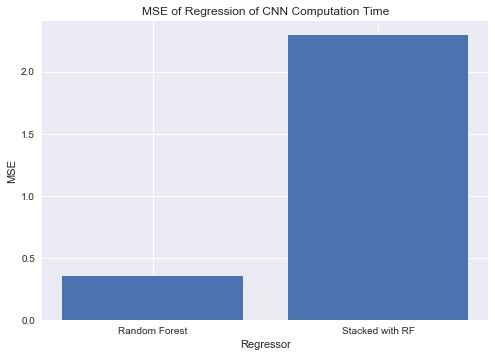

In [143]:
cnn_ms = [cnn_ms_rf_mse, cnn_ms_stacked_1_mse]#,cnn_ms_stacked_2_mse]
plt.bar([i for i in range(len(cnn_ms))], cnn_ms, tick_label=[
    'Random Forest',
    'Stacked with RF',
#     'Stacked with Polynomial',
])
plt.title('MSE of Regression of CNN Computation Time')
plt.ylabel('MSE')

plt.xlabel('Regressor')
plt.show()

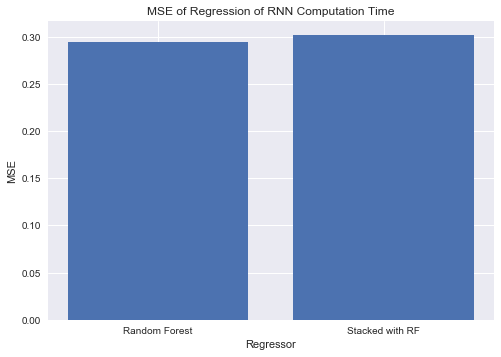

In [47]:
rnn_ms = [rnn_ms_rf_mse, rnn_ms_stacked_1_mse]#, rnn_ms_stacked_2_mse]

plt.bar([i for i in range(len(rnn_ms))], rnn_ms, tick_label=[
    'Random Forest',
    'Stacked with RF',
#     'Stacked with Polynomial',
])
plt.title('MSE of Regression of RNN Computation Time')
plt.ylabel('MSE')

plt.xlabel('Regressor')
plt.show()

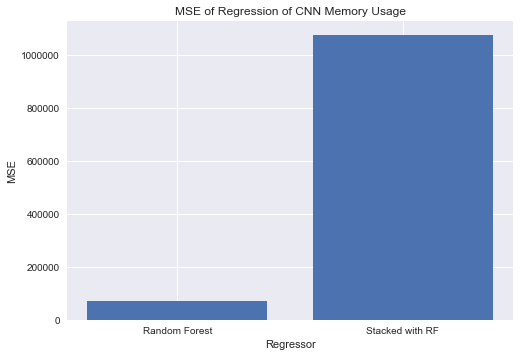

In [48]:
cnn_mem = [cnn_mem_rf_mse, cnn_mem_stacked_1_mse]
plt.bar(range(len(cnn_mem)), cnn_mem, tick_label=["Random Forest", "Stacked with RF"])

plt.title('MSE of Regression of CNN Memory Usage')
plt.ylabel('MSE')
plt.xlabel('Regressor')

plt.show()

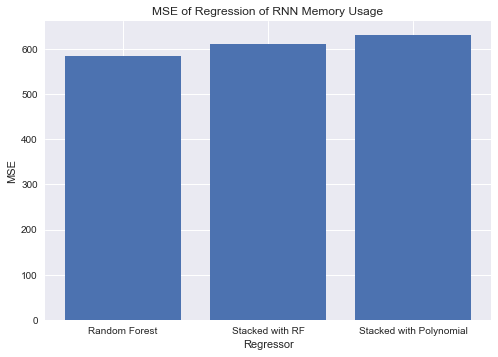

In [49]:
rnn_mem = [rnn_mem_rf_mse, rnn_mem_stacked_1_mse, rnn_mem_stacked_2_mse]

plt.bar(range(len(rnn_mem)), rnn_mem, tick_label=[
    "Random Forest",
    "Stacked with RF",
    "Stacked with Polynomial",
])

plt.title('MSE of Regression of RNN Memory Usage')
plt.ylabel('MSE')
plt.xlabel('Regressor')

plt.show()

In [107]:
def predict_cnn_ms(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = cnn_ms_rf.predict(X)
    
    return pd.DataFrame({'name': cleaned_features['name'], 'pred_ms': predicted})

def predict_cnn_mem(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = cnn_mem_rf.predict(X)
    
    return pd.DataFrame({'name': cleaned_features['name'], 'pred_mem': predicted})

def predict_rnn_ms(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = rnn_ms_rf.predict(X)
    
    return pd.DataFrame({'name': cleaned_features['name'], 'pred_ms': predicted})

def predict_rnn_mem(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = rnn_mem_rf.predict(X)
    
    return pd.DataFrame({'name': cleaned_features['name'], 'pred_mem': predicted})
    



In [108]:
tf.keras.backend.clear_session()
test_model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet')

predict_cnn_ms(test_model).head()

,name,pred_ms
0,input_1,0.236354
1,conv1_pad,0.236354
2,conv1,0.742407
3,bn_conv1,1.356283
4,activation,4.468461


In [109]:
predict_cnn_mem(test_model).head()

,name,pred_mem
0,input_1,458.366976
1,conv1_pad,458.366976
2,conv1,507.565568
3,bn_conv1,430.150784
4,activation,2867.109824


In [110]:
resnet_benchmark = benchmark_model(test_model)
resnet_benchmark.head()

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
0,NoOp,-6.821,0.034,0.014,0.014%,0.014%,0.0,1,_SOURCE,_SOURCE
1,Const,-6.790,0.017,0.005,0.005%,0.019%,0.0,1,bn2b_branch2c/gamma,bn2b_branch2c
2,Const,-6.783,0.004,0.002,0.002%,0.022%,0.0,1,bn2c_branch2b/beta,bn2c_branch2b
3,Const,-6.779,0.004,0.002,0.002%,0.024%,0.0,1,bn3a_branch2c/beta,bn3a_branch2c
4,Const,-6.776,0.003,0.002,0.002%,0.026%,0.0,1,bn3b_branch2c/moving_mean,bn3b_branch2c


In [133]:
resnet_cpu = resnet_benchmark[['name', '[avg ms]']].groupby('name').sum().reset_index()
resnet_mem = resnet_benchmark[['name', '[mem KB]']].groupby('name').max().reset_index()

print(len(resnet_cpu))
print(len(predict_cnn_ms(test_model)))

180
177


In [134]:
resnet_cpu_df = resnet_cpu.merge(predict_cnn_ms(test_model), on='name')
resnet_cpu_df.head()

,name,[avg ms],pred_ms
0,activation,0.142,4.468461
1,activation_1,0.145,1.475160
2,activation_10,0.098,1.424594
3,activation_11,0.054,1.424594
4,activation_12,0.101,1.247037


In [141]:
resnet_mem_df = resnet_mem.merge(predict_cnn_mem(test_model), on='name')
resnet_mem_df.tail(20)

,name,[mem KB],pred_mem
156,res4c_branch2c,802.816,817.317184
157,res4d_branch2a,200.704,0.000000
158,res4d_branch2b,200.704,0.000000
159,res4d_branch2c,802.816,817.317184
160,res4e_branch2a,200.704,0.000000
161,res4e_branch2b,200.704,0.000000
162,res4e_branch2c,802.816,817.317184
163,res4f_branch2a,200.704,0.000000
164,res4f_branch2b,200.704,0.000000
165,res4f_branch2c,802.816,817.317184


In [142]:
print(mean_squared_error(resnet_cpu_df['pred_ms'], resnet_cpu_df['[avg ms]']))
print(mean_squared_error(resnet_mem_df['pred_mem'], resnet_mem_df['[mem KB]']))

4.24975750164106
892257.5725697743


In [54]:
from tensorflow.compat.v1.keras.models import Sequential
# from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

max_features = 20000
maxlen = 100
batch_size = 32
rnn_model = Sequential()
rnn_model.add(layers.Embedding(max_features, 128, input_length=maxlen))
rnn_model.add(layers.Bidirectional(layers.LSTM(64)))
rnn_model.add(layers.Dropout(0.5))
rnn_model.add(layers.Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
rnn_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

predict_rnn_ms(rnn_model)

# get_layer_features(rnn_model)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


array([0.130042, 0.145918, 0.130042, 0.148489])

In [ ]:
predict_rnn_mem(rnn_model)

In [ ]:
clean(get_layer_features(test_model), inference=True)

In [145]:
from joblib import dump, load
dump(cnn_ms_rf, 'nn_regressors/cnn_cpu.joblib') 
dump(cnn_mem_rf, 'nn_regressors/cnn_mem.joblib') 

dump(rnn_ms_rf, 'nn_regressors/rnn_cpu.joblib') 
dump(rnn_mem_rf, 'nn_regressors/rnn_mem.joblib') 

['nn_regressors/rnn_mem.joblib']